In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate
#from simulators.cosmic_shear.cosmic_shear import *
import ndes.nde as nde
import distributions.priors as priors

#Lyman-alpha forest modules & utilities
from compression import *
from likelihood import *
%config IPCompleter.greedy=True

%matplotlib inline

Using Theano backend.
/Users/kwame/Software/SimulationRunner/SimulationRunner/simulationics.py:15: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  F

In [3]:
# Set-up for Lyman-alpha forest simulation code
root_dir = '/home/keir/Data/emulator'
training_dir = root_dir + '/hot_cold'
mock_data_dir = root_dir + '/hot_cold_test/HeliumHeatAmp0.95/output'
theta_fiducial = np.array([0., 0.95, 0.95]) #[dtau0, tau0, HeliumHeatAmp]
n_parameters = theta_fiducial.size

likelihood_instance = LikelihoodClass(training_dir, mock_data_dir, rescale_data_error=True)
emulator_object = likelihood_instance.gpemu
fixed_covariance = likelihood_instance.get_BOSS_covariance_full()
redshift_vector = likelihood_instance.zout

compression_instance = Compression(None, redshift_vector, fixed_covariance, emulator_object, parameter_vector=theta_fiducial)

#Prior (truncated Gaussian)
lower = likelihood_instance.param_limits[:, 0]
upper = likelihood_instance.param_limits[:, 1]
prior_sigma = np.array([0.1, 0.1, 0.1]) #Not uninformative

Q = np.eye(n_parameters) * (prior_sigma ** 2) #Prior covariance
prior_mean = theta_fiducial

#Asymptotic posterior approximation
Finv = compression_instance.get_inverse_Fisher_matrix(theta_fiducial)

#Parameter labelling
names = ['dtau0', 'tau0', 'HeliumHeatAmp']
labels = names
ranges = {names[0]:[lower[0], upper[0]], names[1]:[lower[1], upper[1]], names[2]:[lower[2], upper[2]]}

ValueError: ('Found only', 0, 'of', 11, 'from snaps:', [])

In [3]:
# Define the simulator function: takes parameters, spits out simulated (compressed) summaries
simulator = lambda x: parameter_vector_to_compressed_data_vector_score_function(x, fiducial_parameter_vector, emulator_object, fixed_covariance)
#simulationABC(x, simABC_args)

In [4]:
# The data vector: import or otherwise simulate for testing
data_uncompressed = likelihood_instance.data_fluxpower #P(k_||, z) - decreasing z, then increasing k_|| for each z
#Might want to add BOSS noise realisation
data = data_vector_to_compressed_data_vector_score_function(data_uncompressed, fiducial_parameter_vector, emulator_object, fixed_covariance)
#projected_score(power_spectrum(theta_fiducial, sim_args), projection_args)


In [5]:
# Create prior over parameters
prior = priors.TruncatedGaussian(prior_mean, Q, lower, upper)

# Create asymptotic posterior approximation
asymptotic_posterior = priors.TruncatedGaussian(theta_fiducial, Finv, lower, upper)

In [6]:
# Create the DELFI MDN object
n_components = 1

mdn = nde.DelfiMixtureDensityNetwork(simulator, prior, asymptotic_posterior, Finv, theta_fiducial, data, n_components, n_hidden = [50, 50], activations = ['tanh', 'tanh'], names = names, labels = labels, ranges = ranges)

Training on the pre-training data...
Train on 45000 samples, validate on 5000 samples
Epoch 1/50
45000/45000 [==============================] - 51s 1ms/step - loss: 64.2035 - val_loss: 57.7589
Epoch 2/50
45000/45000 [==============================] - 54s 1ms/step - loss: 51.4969 - val_loss: 17.7055
Epoch 3/50
45000/45000 [==============================] - 51s 1ms/step - loss: 16.5195 - val_loss: 16.3472
Epoch 4/50
45000/45000 [==============================] - 51s 1ms/step - loss: 15.6685 - val_loss: 14.9615
Epoch 5/50
45000/45000 [==============================] - 51s 1ms/step - loss: 14.7996 - val_loss: 14.0041
Epoch 6/50
45000/45000 [==============================] - 51s 1ms/step - loss: 13.8198 - val_loss: 13.1217
Epoch 7/50
45000/45000 [==============================] - 50s 1ms/step - loss: 12.7646 - val_loss: 12.3048
Epoch 8/50
45000/45000 [==============================] - 52s 1ms/step - loss: 11.6385 - val_loss: 11.4972
Epoch 9/50
45000/45000 [==============================] - 

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


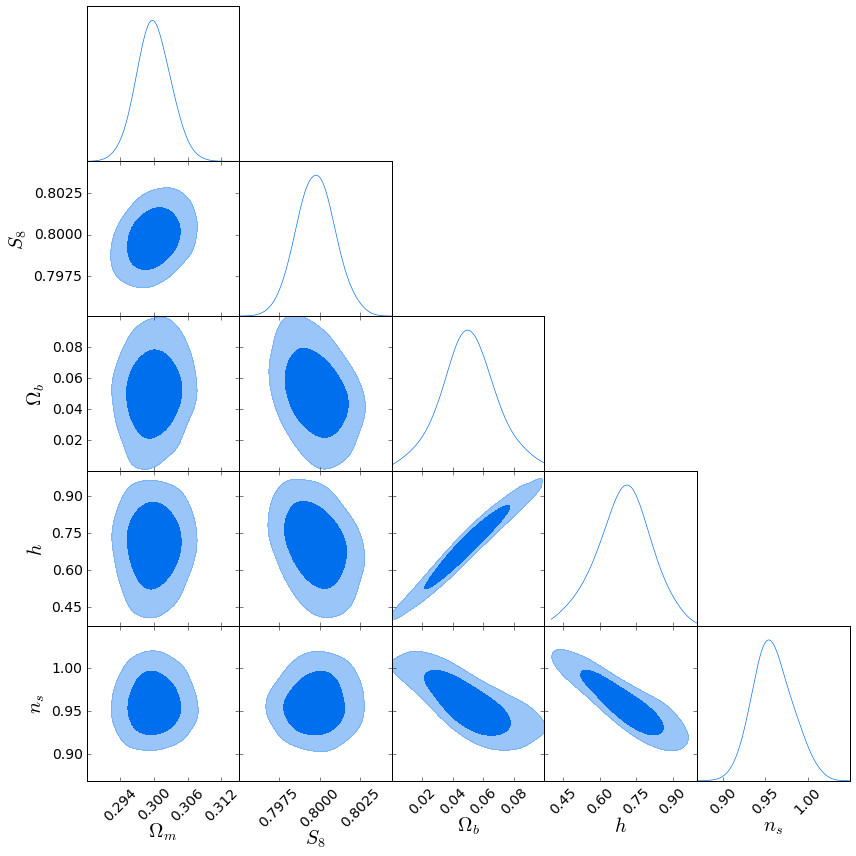

In [7]:
# Proposal for the Fisher pre-training stage
proposal = priors.TruncatedGaussian(prior_mean, Q, lower, upper)

# Do the Fisher pre-training
mdn.fisher_pretraining(50000, proposal, epochs=50)

Running initial 500 sims...
Done.
Train on 450 samples, validate on 50 samples
Epoch 1/100
450/450 [==============================] - 0s 626us/step - loss: 23.2344 - val_loss: 15.9941
Epoch 2/100
450/450 [==============================] - 0s 639us/step - loss: 17.7521 - val_loss: 11.7208
Epoch 3/100
450/450 [==============================] - 0s 641us/step - loss: 11.7310 - val_loss: 9.2414
Epoch 4/100
450/450 [==============================] - 0s 633us/step - loss: 9.1559 - val_loss: 10.3958
Epoch 5/100
450/450 [==============================] - 0s 624us/step - loss: 8.9814 - val_loss: 6.3645
Epoch 6/100
450/450 [==============================] - 0s 631us/step - loss: 7.4092 - val_loss: 6.5440
Epoch 7/100
450/450 [==============================] - 0s 641us/step - loss: 6.9020 - val_loss: 5.8862
Epoch 8/100
450/450 [==============================] - 0s 654us/step - loss: 6.4727 - val_loss: 6.1033
Epoch 9/100
450/450 [==============================] - 0s 635us/step - loss: 6.1526 - val_l

450/450 [==============================] - 0s 630us/step - loss: 4.7424 - val_loss: 4.7014
Epoch 80/100
450/450 [==============================] - 0s 610us/step - loss: 4.7581 - val_loss: 4.7533
Epoch 81/100
450/450 [==============================] - 0s 618us/step - loss: 4.7474 - val_loss: 4.7097
Epoch 82/100
450/450 [==============================] - 0s 627us/step - loss: 4.7106 - val_loss: 4.7273
Epoch 83/100
450/450 [==============================] - 0s 614us/step - loss: 4.7124 - val_loss: 4.6919
Epoch 84/100
450/450 [==============================] - 0s 632us/step - loss: 4.7153 - val_loss: 4.6959
Epoch 85/100
450/450 [==============================] - 0s 613us/step - loss: 4.6872 - val_loss: 4.7514
Epoch 86/100
450/450 [==============================] - 0s 611us/step - loss: 4.6950 - val_loss: 4.6815
Epoch 87/100
450/450 [==============================] - 0s 616us/step - loss: 4.6815 - val_loss: 4.6882
Epoch 88/100
450/450 [==============================] - 0s 609us/step - loss:

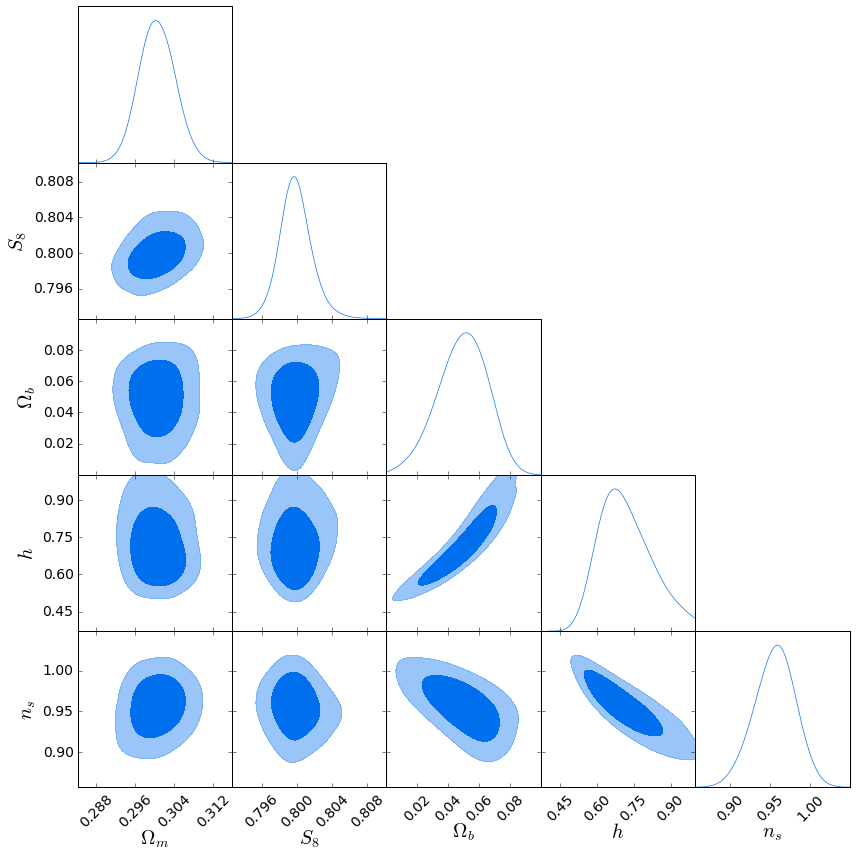

Population 1/8
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 900 samples, validate on 100 samples
Epoch 1/100
900/900 [==============================] - 1s 598us/step - loss: 4.4245 - val_loss: 3.9819
Epoch 2/100
900/900 [==============================] - 1s 624us/step - loss: 4.3982 - val_loss: 3.8264
Epoch 3/100
900/900 [==============================] - 1s 615us/step - loss: 4.3945 - val_loss: 3.8336
Epoch 4/100
900/900 [==============================] - 1s 602us/step - loss: 4.4106 - val_loss: 3.8925
Epoch 5/100
900/900 [==============================] - 1s 602us/step - loss: 4.4258 - val_loss: 3.9103
Epoch 6/100
900/900 [==============================] - 1s 605us/step - loss: 4.3667 - val_loss: 3.8273
Epoch 7/100
900/900 [==============================] - 1s 606us/step - loss: 4.3893 - val_loss: 3.8540
Epoch 8/100
900/900 [==============================] - 1s 617us/step - loss: 4.3593 - val_loss: 3.8201
Epoch 9/100
900/900 [==============================] -

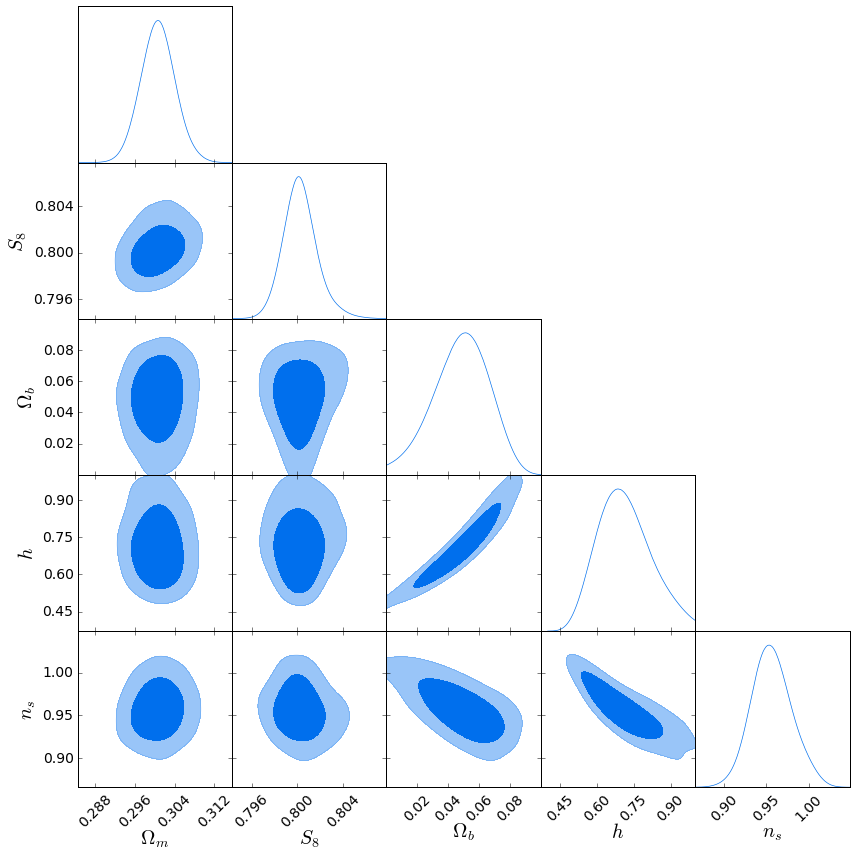

Population 2/8
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 1350 samples, validate on 150 samples
Epoch 1/100
1350/1350 [==============================] - 1s 612us/step - loss: 3.9866 - val_loss: 4.2511
Epoch 2/100
1350/1350 [==============================] - 1s 603us/step - loss: 3.9823 - val_loss: 4.1488
Epoch 3/100
1350/1350 [==============================] - 1s 614us/step - loss: 4.0305 - val_loss: 4.2209
Epoch 4/100
1350/1350 [==============================] - 1s 684us/step - loss: 4.0491 - val_loss: 4.2793
Epoch 5/100
1350/1350 [==============================] - 1s 603us/step - loss: 3.9690 - val_loss: 4.1874
Epoch 6/100
1350/1350 [==============================] - 1s 871us/step - loss: 3.9706 - val_loss: 4.3004
Epoch 7/100
1350/1350 [==============================] - 1s 575us/step - loss: 4.0066 - val_loss: 4.2515
Epoch 8/100
1350/1350 [==============================] - 1s 567us/step - loss: 4.0132 - val_loss: 4.1784
Epoch 9/100
1350/1350 [==============

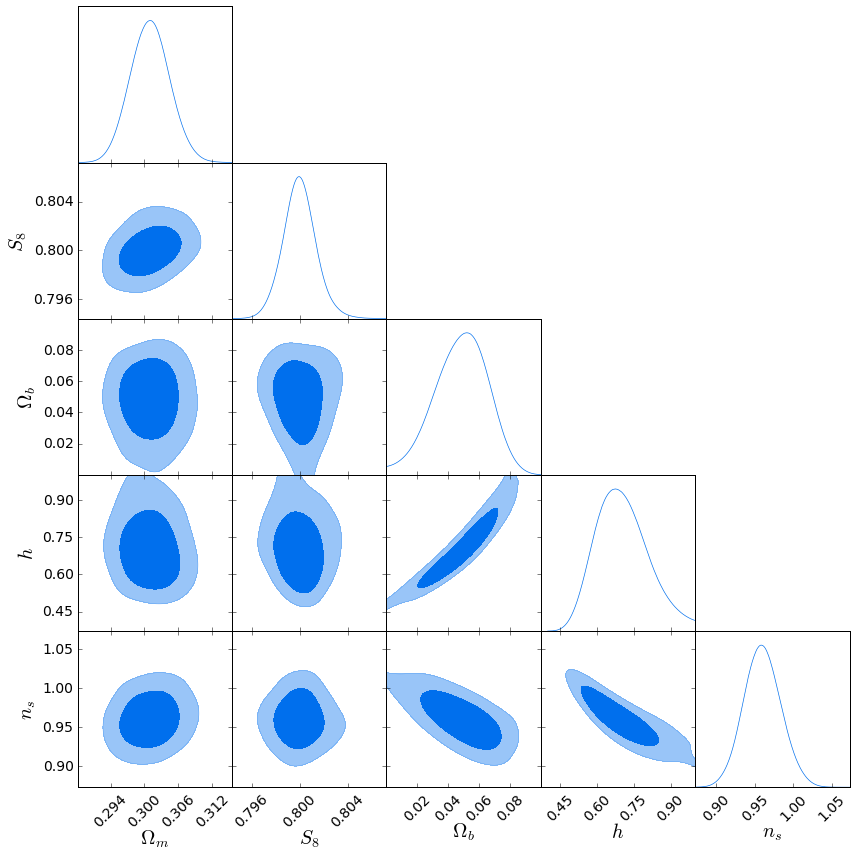

Population 3/8
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 1800 samples, validate on 200 samples
Epoch 1/100
1800/1800 [==============================] - 1s 563us/step - loss: 3.9719 - val_loss: 4.2208
Epoch 2/100
1800/1800 [==============================] - 1s 565us/step - loss: 4.0388 - val_loss: 4.8695
Epoch 3/100
1800/1800 [==============================] - 1s 559us/step - loss: 4.0875 - val_loss: 4.3806
Epoch 4/100
1800/1800 [==============================] - 1s 557us/step - loss: 3.9745 - val_loss: 4.2079
Epoch 5/100
1800/1800 [==============================] - 1s 561us/step - loss: 3.9571 - val_loss: 4.1219
Epoch 6/100
1800/1800 [==============================] - 1s 566us/step - loss: 3.9447 - val_loss: 4.2042
Epoch 7/100
1800/1800 [==============================] - 1s 574us/step - loss: 3.9307 - val_loss: 4.1493
Epoch 8/100
1800/1800 [==============================] - 1s 675us/step - loss: 3.9152 - val_loss: 4.5576
Epoch 9/100
1800/1800 [==============

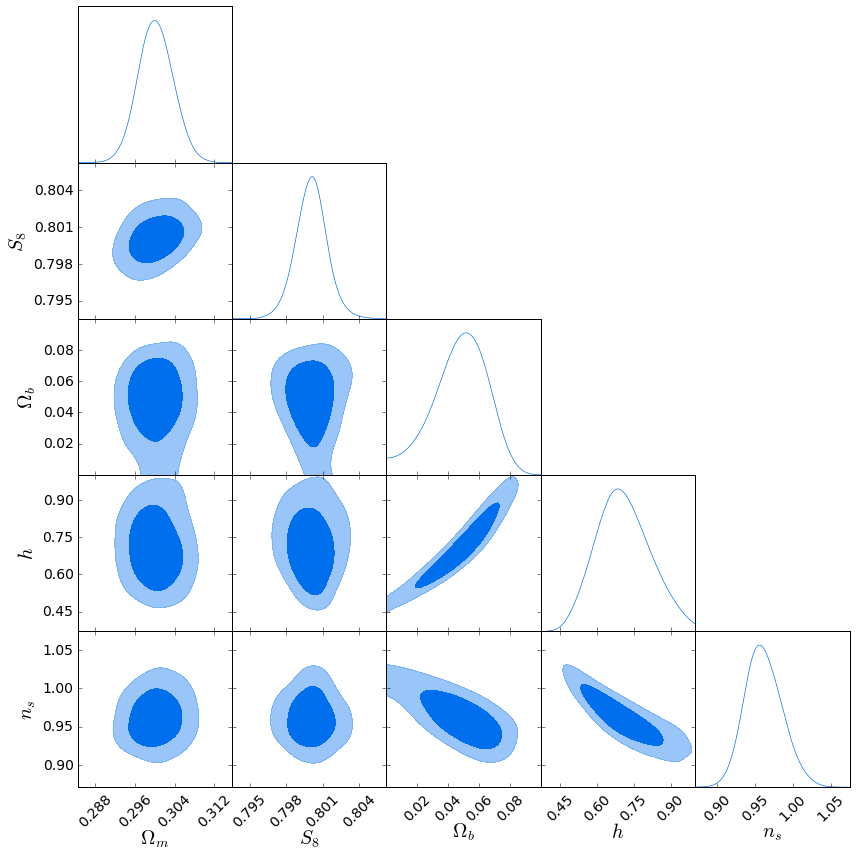

Population 4/8
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 2250 samples, validate on 250 samples
Epoch 1/100
1800/2250 [=======================>......] - ETA: 0s - loss: 4.0998

In [ ]:
# Proposal for the SNL
proposal = priors.TruncatedGaussian(theta_fiducial, 9*Finv, lower, upper)

# Initial samples, batch size for population samples, number of populations
n_initial = 500
n_batch = 500
n_populations = 8

# Do the SNL training
mdn.sequential_training(n_initial, n_batch, n_populations, proposal)

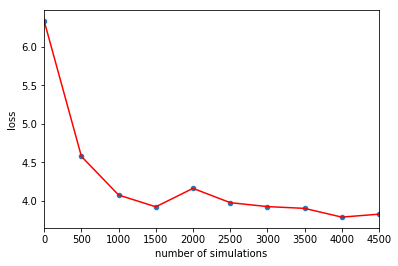

In [10]:
# Trace plot of the loss as a function of the number of simulations
plt.scatter(mdn.n_sim_trace, mdn.loss_trace, s = 20)
plt.plot(mdn.n_sim_trace, mdn.loss_trace, color = 'red')
plt.xlim(0, mdn.n_sim_trace[-1])
plt.xlabel('number of simulations')
plt.ylabel('loss')
plt.show()